In [2]:
import numpy as np
import glob
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

import cv2

MODELLIST = ["OriginalLRData", "AutoEncoder", "VGLCLSTM", "AutoEncoderwATT"]

In [3]:
def pointOnLine(a, b, p):
    # From: https://stackoverflow.com/questions/61341712/calculate-projected-point-location-x-y-on-given-line-startx-y-endx-y
    ap = p - a
    ab = b - a
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    return result

Level Image Being Loaded: ../data/vglc/Lode Runner/Original_Fixed_Tom/Level 137.png
Level String Being Loaded: ../data/vglc/Lode Runner/Processed/Level 137.txt


(-25.200000000000003, 529.2, 8.0, 360.0)

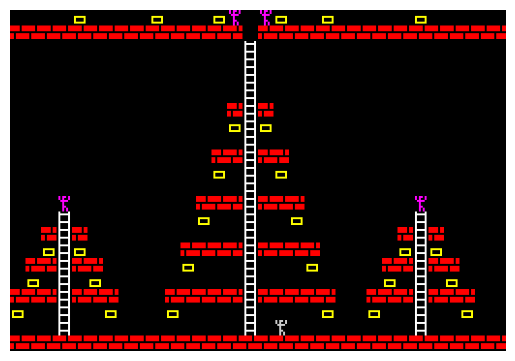

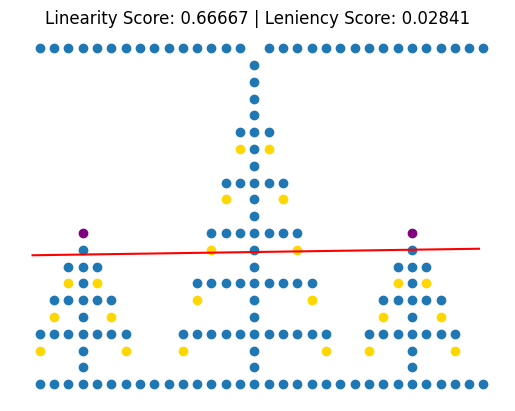

In [4]:
levelNum = 42

lrLevelPaths = sorted(glob.glob("../data/vglc/Lode Runner/Original_Fixed_Tom/Level*.png"))
print(f"Level Image Being Loaded: {lrLevelPaths[levelNum]}")

lrStringLevelPaths = sorted(glob.glob("../data/vglc/Lode Runner/Processed/Level*.txt"))
print(f"Level String Being Loaded: {lrStringLevelPaths[levelNum]}")

with open(lrStringLevelPaths[levelNum], "r") as f:
    levelString = np.array([list(line[:-1]) for line in f.readlines()])

levelImage = cv2.cvtColor(cv2.imread(lrLevelPaths[levelNum]), cv2.COLOR_BGR2RGB)

midPointsOfPlatforms = []
distances = []
levelWeight = 0

enemies = []
coins = []

for i in range((levelImage.shape[0] // 16) - 1, 0, -1):

    rowImages = []
    rowAffordances = []

    for j in range(0, levelImage.shape[1] // 16):

        y = i * 16
        x = j * 16

        rowImages.append(levelImage[y:y+16, x:x+16, :])
        rowAffordances.append(levelString[i, j])

        if levelString[i, j] in ['b', 'B', '-', '#']:
            midPointsOfPlatforms.append([x+8, 352 - y+8])
        
        
        if levelString[i, j] == 'E':
            levelWeight -= 1
            enemies.append([x+8, 352 - y+8])
        
        if levelString[i, j] == 'G':
            levelWeight += 1
            coins.append([x+8, 352 - y+8])

midPointsOfPlatforms = np.array(midPointsOfPlatforms)
enemies = np.array(enemies)
coins = np.array(coins)

linRegModel = np.polyfit(midPointsOfPlatforms[:, 0], midPointsOfPlatforms[:, 1], 1)
linRegPredict = np.poly1d(linRegModel)

p1 = np.array([0, linRegPredict(0)])
p2 = np.array([500, linRegPredict(500)])

for point in midPointsOfPlatforms:
    point = np.array(point)
    projectedPoint = pointOnLine(p1, p2, point)
    dist = np.linalg.norm(point-projectedPoint)
    distances.append(dist)

xPoints = np.arange(0, 500)

plt.figure()
plt.imshow(levelImage)
plt.axis(False)

plt.figure()
plt.scatter(midPointsOfPlatforms[:, 0], midPointsOfPlatforms[:, 1])

if enemies.shape[0] > 0:
    plt.scatter(enemies[:, 0], enemies[:, 1], c='purple')

if coins.shape[0] > 0:
    plt.scatter(coins[:, 0], coins[:, 1], c='gold')
plt.plot(xPoints, linRegPredict(xPoints), c='r')
plt.title(f"Linearity Score: {round((sum(distances)/len(distances))/len(distances), 5)} | Leniency Score: {round(levelWeight/(22*32), 5)}")
plt.axis(False)

In [5]:
MODELDICTIONARY = {}

for model in MODELLIST:

    print("Model", model)

    distancesNorm = []
    levelWeights = []

    MODELDICTIONARY[model] = {}

    lrLevelPaths = sorted(glob.glob(f"Models/{model}/LodeRunnerLevels/images/Level*.png"))
    print(f"Level Paths Loaded: {len(lrLevelPaths)}")

    lrStringLevelPaths = sorted(glob.glob(f"Models/{model}/LodeRunnerLevels/txts/Level*.txt"))
    print(f"Level String Paths Loaded: {len(lrStringLevelPaths)}")

    # Linearity and Liniency calculations
    for l in range(0, len(lrLevelPaths)):

        with open(lrStringLevelPaths[l], "r") as f:
            levelString = np.array([list(line[:-1]) for line in f.readlines()])
        
        levelImage = cv2.cvtColor(cv2.imread(lrLevelPaths[l]), cv2.COLOR_BGR2RGB)

        midPointsOfPlatforms = []
        levelWeight = 0

        for i in range((levelImage.shape[0] // 16) - 1, 0, -1):

            rowImages = []
            rowAffordances = []

            for j in range(0, levelImage.shape[1] // 16):

                y = i * 16
                x = j * 16

                rowImages.append(levelImage[y:y+16, x:x+16, :])
                rowAffordances.append(levelString[i, j])
                
                if levelString[i, j] in ['b', 'B', '-', '#']:
                    midPointsOfPlatforms.append([x+8, 352 - y+8])
                
                if levelString[i, j] == 'E':
                    levelWeight -= 1
                
                if levelString[i, j] == 'G':
                    levelWeight += 1

        midPointsOfPlatforms = np.array(midPointsOfPlatforms)

        linRegModel = np.polyfit(midPointsOfPlatforms[:, 0], midPointsOfPlatforms[:, 1], 1)
        linRegPredict = np.poly1d(linRegModel)

        p1 = np.array([0, linRegPredict(0)])
        p2 = np.array([500, linRegPredict(500)])

        distances = []

        for point in midPointsOfPlatforms:
            point = np.array(point)
            projectedPoint = pointOnLine(p1, p2, point)
            dist = np.linalg.norm(point-projectedPoint)
            distances.append(dist)

        print(f"Distance Average: {sum(distances)/len(distances)}")
        print(f"Distance Array Length: {len(distances)}")
        print(f"Distance Average Normed: {(sum(distances)/len(distances))/len(distances)}")

        print(f"Level Weight: {levelWeight}")
        print(f"Level Weight Averaged: {levelWeight/(22*32)}")

        distancesNorm.append((sum(distances)/len(distances))/len(distances))

        levelWeights.append(levelWeight/(22*32))

    MODELDICTIONARY[model]["distanceNorms"] = distancesNorm
    MODELDICTIONARY[model]["levelWeights"] = levelWeights

Model OriginalLRData
Level Paths Loaded: 150
Level String Paths Loaded: 150
Distance Average: 90.3931161565517
Distance Array Length: 196
Distance Average Normed: 0.4611893681456719
Level Weight: 2
Level Weight Averaged: 0.002840909090909091
Distance Average: 81.37303714512639
Distance Array Length: 230
Distance Average Normed: 0.35379581367446256
Level Weight: 7
Level Weight Averaged: 0.009943181818181818
Distance Average: 68.43536056159016
Distance Array Length: 260
Distance Average Normed: 0.2632129252368852
Level Weight: 22
Level Weight Averaged: 0.03125
Distance Average: 66.99252837107512
Distance Array Length: 271
Distance Average Normed: 0.2472049017382846
Level Weight: 20
Level Weight Averaged: 0.028409090909090908
Distance Average: 89.94017783162231
Distance Array Length: 163
Distance Average Normed: 0.5517802320958424
Level Weight: 12
Level Weight Averaged: 0.017045454545454544
Distance Average: 80.07503098259129
Distance Array Length: 222
Distance Average Normed: 0.360698337

Model OriginalLRData | color green
Model AutoEncoder | color orange
Model VGLCLSTM | color purple
Model AutoEncoderwATT | color black


/tmp/ipykernel_18777/4062467907.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


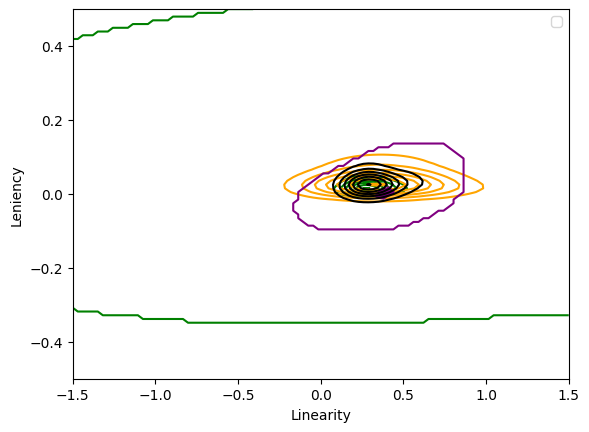

In [6]:
import scipy.stats as st

limitx = 1.5
limity = 0.5

xmin, xmax = -limitx, limitx
ymin, ymax = -limity, limity

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

ax.set_xlabel('Linearity')
ax.set_ylabel('Leniency')

colors = ['green', 'orange', 'purple', 'black']

for i, model in enumerate(MODELLIST):

    print(f"Model {model} | color {colors[i]}")

    distanceNorms = MODELDICTIONARY[model]['distanceNorms']
    levelWeights = MODELDICTIONARY[model]['levelWeights']

    data = np.concatenate((np.array(distanceNorms).reshape(len(distanceNorms), 1), np.array(levelWeights).reshape(len(levelWeights), 1)), axis=1)
    x = data[:, 0]
    y = data[:, 1]

    # Peform the kernel density estimate
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # Contourf plot
    cfset = ax.contourf(xx, yy, f, colors='white')
    ## Or kernel density estimate plot instead of the contourf plot
    #ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
    # Contour plot
    ax.contour(xx, yy, f, colors=colors[i])
    # Label plot
    #ax.clabel(cset, inline=1, fontsize=10)

plt.legend()
plt.show()